<a href="https://colab.research.google.com/github/vladislavdarii/Ship-classification-using-Machine-Learning-techniques/blob/main/08_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title 1.0 Imports for Model Training
#Train and test data variables have been saved executing 0.5 to 3.2

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from keras.layers import Dense, LSTM, Dropout, GRU

#Machine learning
from keras import models
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.layers import Dropout
import matplotlib.pyplot as plt
import librosa
#Writing and loading variables
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

#Model visualization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau

#Mount drive
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title 1.1 Function: Class Accuracy Plot and Metrics

def plot_class_acc(y_val, y_pred, strr):

  # Initialize the lists for correctly and incorrectly predicted values
  correct_preds = [0, 0, 0, 0]
  incorrect_preds = [0, 0, 0, 0]

  # Loop over the samples in y_test and y_pred
  for i in range(len(y_val)):
      if y_val[i] == y_pred[i]:
          correct_preds[y_val[i]] += 1
      else:
          incorrect_preds[y_val[i]] += 1

  # Set the colors for the bars
  bar_colors = ['#009965', '#a52a2b']

  # Create the bar chart with two parts for each bar
  fig, ax = plt.subplots(figsize=(8, 5))
  ax.bar(range(len(correct_preds)), correct_preds, color=bar_colors[0], label='Correct Predictions')
  ax.bar(range(len(incorrect_preds)), incorrect_preds, bottom=correct_preds, color=bar_colors[1], label='Incorrect Predictions')

  for i, (corr, incorr) in enumerate(zip(correct_preds, incorrect_preds)):
      ax.text(i, corr/2, str(corr), ha='center', va='center', color='white', fontsize=10, fontweight='bold')
      ax.text(i, corr + incorr/2, str(incorr), ha='center', va='center', color='white', fontsize=10, fontweight='bold')

  # Set the x-ticks and labels
  ax.set_xticks(range(len(correct_preds)))
  ax.set_xticklabels(['Class A', 'Class B', 'Class C', 'Class D'])

  # Set the labels and title
  ax.set_xlabel('Boat Type')
  ax.set_ylabel('Count')
  ax.set_title(strr)

  # Add the legend
  ax.legend()

  # Show the plot
  plt.show()

  # #Metric calculation
  # Create confusion matrix
  cm = confusion_matrix(y_val, y_pred)

  # Convert the confusion matrix to a pandas DataFrame
  confusion_matrix_df = pd.DataFrame(cm, columns=['Class A', 'Class B', 'Class C', 'Class D'])

  # Calculate metrics
  metrics_df = calculate_metrics(confusion_matrix_df.values)

  # Print the results
  print("Confusion Matrix:")
  print(confusion_matrix_df)
  print("\nMetrics:")
  print(metrics_df)

  return metrics_df, confusion_matrix_df

def calculate_metrics(confusion_matrix):
    tp = np.diagonal(confusion_matrix)
    fp = confusion_matrix.sum(axis=0) - tp
    fn = confusion_matrix.sum(axis=1) - tp
    tn = confusion_matrix.sum() - (tp + fp + fn)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.trace(confusion_matrix) / confusion_matrix.sum()

    metrics_dict = {
        'Class': ['Class 0', 'Class 1', 'Class 2', 'Class 3'],
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Accuracy': accuracy
    }
    #Get rid of NaN values
    metrics_dict = pd.DataFrame(metrics_dict)
    metrics_dict.fillna(0, inplace=True)
    return metrics_dict

#@title 5.1 Get final metrics

def metrics_avg_var(metrics):
 row = [0,1,2,3]
 Precision = []
 Recall = []
 F1_Score = []
 Accuracy = []
 Precision_var = []
 Recall_var = []
 F1_Score_var = []
 Accuracy_var = []

 for a in row:
  Precision.append(np.average([df.loc[a, 'Precision'] for df in metrics]))
  Recall.append(np.average([df.loc[a, 'Recall'] for df in metrics]))
  F1_Score.append(np.average([df.loc[a, 'F1 Score'] for df in metrics]))
  Accuracy.append(np.average([df.loc[a, 'Accuracy'] for df in metrics]))
  Precision_var.append(np.std([df.loc[a, 'Precision'] for df in metrics]))
  Recall_var.append(np.std([df.loc[a, 'Recall'] for df in metrics]))
  F1_Score_var.append(np.std([df.loc[a, 'F1 Score'] for df in metrics]))
  Accuracy_var.append(np.std([df.loc[a, 'Accuracy'] for df in metrics]))

 metrics_dict = {
        'Class': ['Class 0', 'Class 1', 'Class 2', 'Class 3'],
        'Precision': Precision,
        'P_std' : Precision_var,
        'Recall': Recall,
        'R_std' : Recall_var,
        'F1 Score': F1_Score,
        'F1_std': F1_Score_var,
        'Accuracy': Accuracy,
        'Acc_std': Accuracy_var
    }


 return pd.DataFrame(metrics_dict)

In [ ]:
#@title 1.2 Model repersentation

def modelrepresent(history):

  plt.figure(figsize=(10, 5))
  plt.grid(True, linestyle='--', alpha=0.6)

  # Plot accuracy and validation accuracy on the left y-axis
  plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
  plt.ylabel('Accuracy', color='blue')
  plt.ylim(0,1)
  plt.xlabel('Epoch')
  plt.twinx()  # Create a second y-axis
  plt.plot(history.history['loss'], label='Train Loss', color='red')
  plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
  plt.ylabel('Loss', color='red')
  plt.title('Accuracy and Loss')
  plt.xlabel('Epoch')
  plt.legend(loc='upper left')
  plt.show()
  return

In [ ]:
#@title 2.1 Data Load

def dataload(datax):
  # Define the directory where the file is saved
  directory = "./drive/MyDrive/TFG/Data/"

  # Load the variables from the file
  with open(os.path.join(directory, datax), "rb") as f:
      X_train, X_test, X_val, y_train, y_test, y_val = pickle.load(f)

  y_train = np.array(y_train)
  y_val = np.array(y_val)
  y_test = np.array(y_test)
  return X_train, X_test, X_val, y_train, y_test, y_val

def save_model(model,modeltype,n):

  model_filename = "GRU_" + str(modeltype) +  "_" + str(n) + ".pkl"

  # Define the directory where you want to save the file
  directory = "./drive/MyDrive/TFG/Models/GRU/"  #change to /RF to actually overwrite stored models

  # Save the variables to a file
  with open(os.path.join(directory, model_filename), "wb") as f:
      pickle.dump((model), f)
  return

In [ ]:
#@title 3.1 Feature extraction: PSD

def get_psd():

  psd_train = []
  psd_test = []
  psd_val = []

  # Calculate the zero-crossing rate for X_train
  for audio in X_train:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024) # best so far 2*1024
    psd_train.append(S/max(S))

  psd_train = np.array(psd_train)

  # Calculate the zero-crossing rate for X_val
  for audio in X_val:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024)
    psd_val.append(S/max(S))

  psd_val = np.array(psd_val)

  # Calculate the zero-crossing rate for X_test
  for audio in X_test:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024)
    psd_test.append(S/max(S))

  psd_test = np.array(psd_test)
  return psd_train, psd_val, psd_test

In [ ]:
#@title 3.2 Feature extraction: MFCC
def get_mfcc():
# Define the frame length and hop length in samples
  frame_length = 2000
  hop_length =  1000

  # Define the number of MFCCs to extract
  num_mfcc = 15

  # Define the sampling rate of the audio signals
  sr = 52734

  mfcc_train = []
  mfcc_val = []
  mfcc_test = []

  # Extract MFCC features for the training set
  for audio in X_train:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length)#, fmin = 25, fmax = 7500)
      mfcc_train.append(mfcc.flatten())

  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_train = np.array(mfcc_train)


  # Extract MFCC features for the validation set
  for audio in X_val:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length)#, fmin = 25, fmax = 7500)
      mfcc_val.append(mfcc.flatten())


  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_val = np.array(mfcc_val)

  # Extract MFCC features for the test set
  for audio in X_test:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length )#,fmin = 25, fmax = 7500)
      mfcc_test.append(mfcc.flatten())

  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_test = np.array(mfcc_test)
  return  mfcc_train, mfcc_val, mfcc_test

In [ ]:
#@title 3.3 LSTM Restruct
def restruct(n,m,vector):
  num_moments = n
  coefficients_per_moment = m

  # Reshape the MFCC vectors to create the restructured MFCC matrix
  x =  vector.reshape(vector.shape[0], num_moments, coefficients_per_moment)
  return x

In [ ]:
#@title RAW GRU
def get_GRU_raw(n):


  model = Sequential()
  model.add(GRU(128,input_shape=(200,25),return_sequences=True))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())

  model.add(GRU(64,return_sequences=True))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())

  model.add(GRU(32))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())


  model.add(Dense(32, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(16, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(4, activation='softmax'))
  # Compile the model
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00005, verbose=1)


  # Train the model
  history = model.fit(X_train_r, y_train, validation_data=(X_val_r, y_val), epochs=100, batch_size=128, callbacks = [reduce_lr])
  save_model(model,"raw",n)

  y_pred = model.predict(X_test_r)
  y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
  metrics, matrix = plot_class_acc(y_test, y_pred, "Test Data")
  return metrics, matrix

In [ ]:
#@title GRU MFCC
def get_GRU_mfcc(n):# Build the GRU model
  model = Sequential()
  model.add(GRU(128,input_shape=(6,15),return_sequences=True))
  model.add(Dropout(0.2))

  model.add(GRU(64))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())


  model.add(Dense(32, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(16, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(4, activation='softmax'))
  # Compile the model
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00005, verbose=1)
  model.summary()

  # Train the model
  history = model.fit(mfcc_train_r, y_train, validation_data=(mfcc_val_r, y_val), epochs=90, batch_size=128, callbacks = [reduce_lr])

  y_pred = model.predict(mfcc_test_r)
  y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
  metrics, matrix = plot_class_acc(y_test, y_pred, "Test Data")
  save_model(model,"mfcc",n)

  return metrics, matrix

In [ ]:
#@title GRU PSD
def get_GRU_psd(n):
    # Build the LSTM model
    model = Sequential()
    model.add(GRU(128,input_shape=(1,1025),return_sequences=True))
    model.add(Dropout(0.2))

    model.add(GRU(64))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())


    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(4, activation='softmax'))
    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00005, verbose=1)
    model.summary()

    # Train the model
    history = model.fit(psd_train_r, y_train, validation_data=(psd_val_r, y_val), epochs=120, batch_size=128, callbacks = [reduce_lr])

    y_pred = model.predict(psd_test_r)
    y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
    metrics, matrix = plot_class_acc(y_test, y_pred, "Test Data")
    save_model(model,"psd",n)
    return metrics, matrix

Epoch 1/100
43/43 [==============================] - 10s 53ms/step - loss: 1.9574 - accuracy: 0.2707 - val_loss: 1.3579 - val_accuracy: 0.3455 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 1s 28ms/step - loss: 1.6948 - accuracy: 0.2967 - val_loss: 1.3435 - val_accuracy: 0.3607 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 1s 28ms/step - loss: 1.6155 - accuracy: 0.3033 - val_loss: 1.3417 - val_accuracy: 0.3687 - lr: 0.0010
Epoch 4/100
43/43 [==============================] - 1s 28ms/step - loss: 1.5213 - accuracy: 0.3205 - val_loss: 1.3412 - val_accuracy: 0.3680 - lr: 0.0010
Epoch 5/100
43/43 [==============================] - 1s 28ms/step - loss: 1.4824 - accuracy: 0.3302 - val_loss: 1.3324 - val_accuracy: 0.3847 - lr: 0.0010
Epoch 6/100
43/43 [==============================] - 1s 28ms/step - loss: 1.4437 - accuracy: 0.3356 - val_loss: 1.3309 - val_accuracy: 0.3898 - lr: 0.0010
Epoch 7/100
43/43 [==============================] - 1s 28ms/step - l

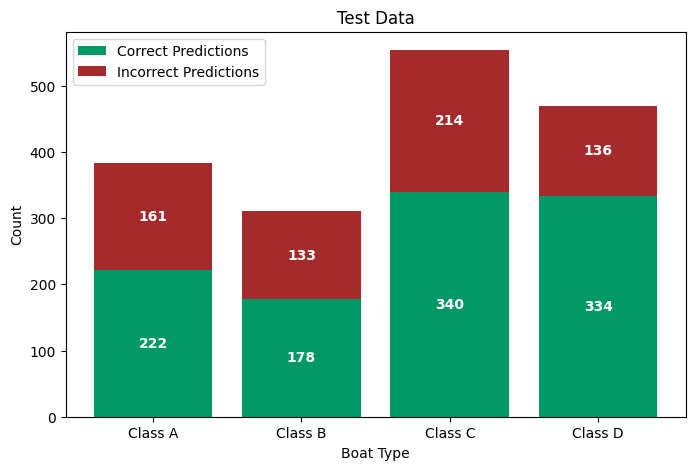

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      222       40       25       96
1       29      178       58       46
2       60      103      340       51
3       66       22       48      334

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.588859  0.579634  0.584211  0.625146
1  Class 1   0.518950  0.572347  0.544343  0.625146
2  Class 2   0.721868  0.613718  0.663415  0.625146
3  Class 3   0.633776  0.710638  0.670010  0.625146
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_21 (GRU)                (None, 6, 128)            55680     
                                                                 
 dropout_39 (Dropout)        (None, 6, 128)            0         
                                                                 
 gru_22 (GRU)                (None, 64)                37248     
                                      

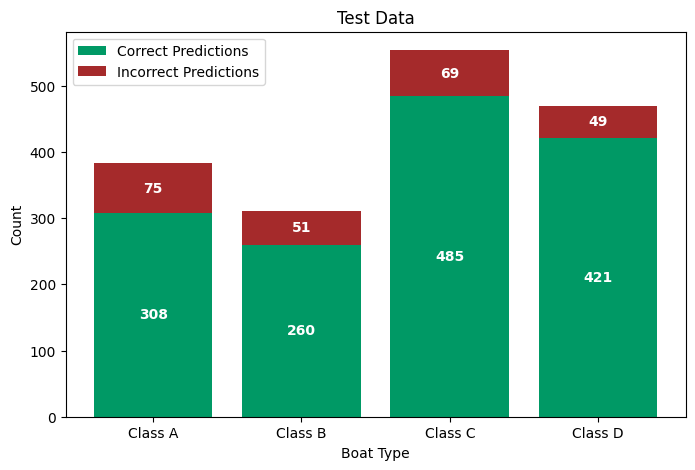

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      308       17       30       28
1       14      260       32        5
2       28       21      485       20
3       26        8       15      421

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.819149  0.804178  0.811594  0.857974
1  Class 1   0.849673  0.836013  0.842788  0.857974
2  Class 2   0.862989  0.875451  0.869176  0.857974
3  Class 3   0.888186  0.895745  0.891949  0.857974
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_23 (GRU)                (None, 1, 128)            443520    
                                                                 
 dropout_43 (Dropout)        (None, 1, 128)            0         
                                                                 
 gru_24 (GRU)                (None, 64)                37248     
                                     

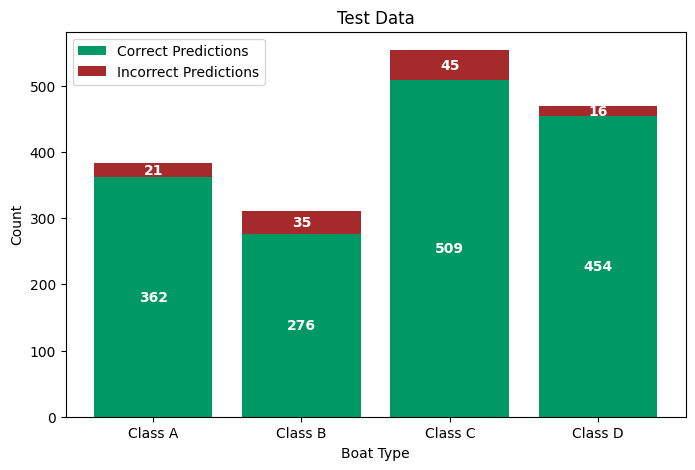

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      362        7        4       10
1       12      276       19        4
2       17       18      509       10
3        6        3        7      454

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.911839  0.945170  0.928205  0.931898
1  Class 1   0.907895  0.887460  0.897561  0.931898
2  Class 2   0.944341  0.918773  0.931382  0.931898
3  Class 3   0.949791  0.965957  0.957806  0.931898
Epoch 1/100
43/43 [==============================] - 10s 54ms/step - loss: 1.8373 - accuracy: 0.2627 - val_loss: 1.3741 - val_accuracy: 0.2960 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 1s 30ms/step - loss: 1.6411 - accuracy: 0.2752 - val_loss: 1.3472 - val_accuracy: 0.3469 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 1s 29ms/step - loss: 1.5290 - accuracy: 0.2914 - val_loss: 1.3343 - val_accuracy: 0.3629 - lr: 0.0010
Epoch 4/100
43/43 [==============================] - 1s 

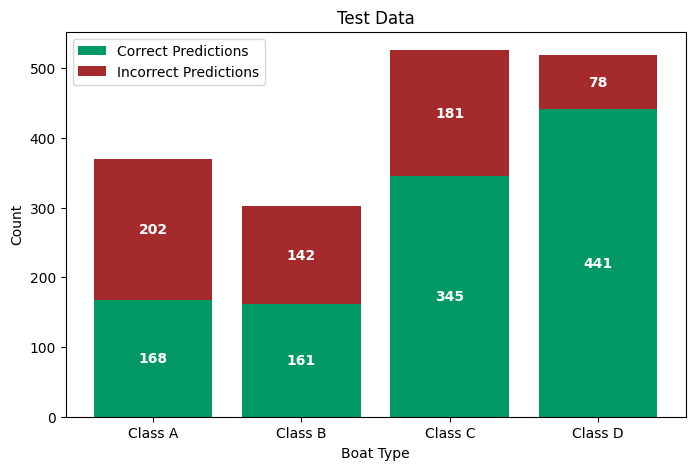

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      168       26       24      152
1       21      161       57       64
2       49       64      345       68
3       30       17       31      441

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.626866  0.454054  0.526646   0.64901
1  Class 1   0.600746  0.531353  0.563923   0.64901
2  Class 2   0.754923  0.655894  0.701933   0.64901
3  Class 3   0.608276  0.849711  0.709003   0.64901
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_28 (GRU)                (None, 6, 128)            55680     
                                                                 
 dropout_52 (Dropout)        (None, 6, 128)            0         
                                                                 
 gru_29 (GRU)                (None, 64)                37248     
                                     

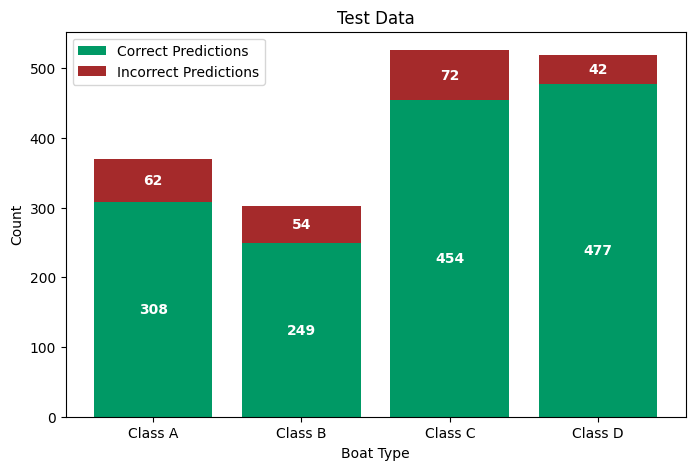

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      308        8       29       25
1       12      249       28       14
2       25       29      454       18
3       19       11       12      477

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.846154  0.832432  0.839237  0.866123
1  Class 1   0.838384  0.821782  0.830000  0.866123
2  Class 2   0.868069  0.863118  0.865586  0.866123
3  Class 3   0.893258  0.919075  0.905983  0.866123
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_30 (GRU)                (None, 1, 128)            443520    
                                                                 
 dropout_56 (Dropout)        (None, 1, 128)            0         
                                                                 
 gru_31 (GRU)                (None, 64)                37248     
                                     

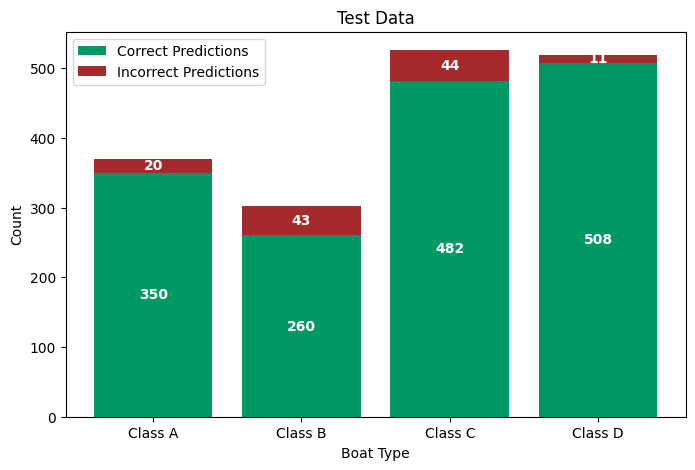

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      350        5       10        5
1        9      260       30        4
2       21       13      482       10
3        3        1        7      508

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.913838  0.945946  0.929615  0.931315
1  Class 1   0.931900  0.858086  0.893471  0.931315
2  Class 2   0.911153  0.916350  0.913744  0.931315
3  Class 3   0.963947  0.978805  0.971319  0.931315
Epoch 1/100
43/43 [==============================] - 11s 55ms/step - loss: 1.9109 - accuracy: 0.2707 - val_loss: 1.3625 - val_accuracy: 0.3440 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 1s 30ms/step - loss: 1.6608 - accuracy: 0.3007 - val_loss: 1.3450 - val_accuracy: 0.3542 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 1s 29ms/step - loss: 1.5395 - accuracy: 0.3240 - val_loss: 1.3379 - val_accuracy: 0.3767 - lr: 0.0010
Epoch 4/100
43/43 [==============================] - 1s 

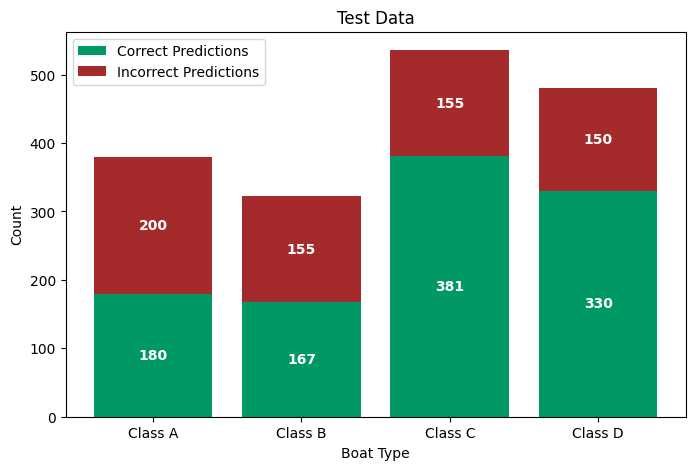

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      180       60       71       69
1       33      167       95       27
2       41       71      381       43
3       42       46       62      330

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.608108  0.473684  0.532544  0.615832
1  Class 1   0.485465  0.518634  0.501502  0.615832
2  Class 2   0.625616  0.710821  0.665502  0.615832
3  Class 3   0.703625  0.687500  0.695469  0.615832
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_35 (GRU)                (None, 6, 128)            55680     
                                                                 
 dropout_65 (Dropout)        (None, 6, 128)            0         
                                                                 
 gru_36 (GRU)                (None, 64)                37248     
                                     

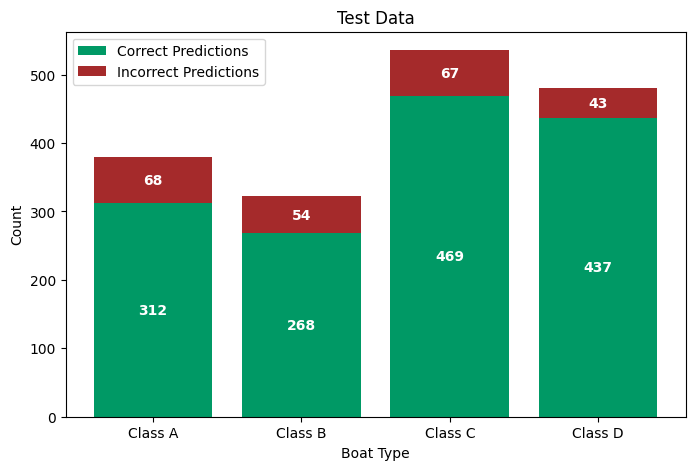

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      312       13       19       36
1        9      268       28       17
2       27       23      469       17
3       18        7       18      437

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.852459  0.821053  0.836461  0.864959
1  Class 1   0.861736  0.832298  0.846761  0.864959
2  Class 2   0.878277  0.875000  0.876636  0.864959
3  Class 3   0.861933  0.910417  0.885512  0.864959
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_37 (GRU)                (None, 1, 128)            443520    
                                                                 
 dropout_69 (Dropout)        (None, 1, 128)            0         
                                                                 
 gru_38 (GRU)                (None, 64)                37248     
                                     

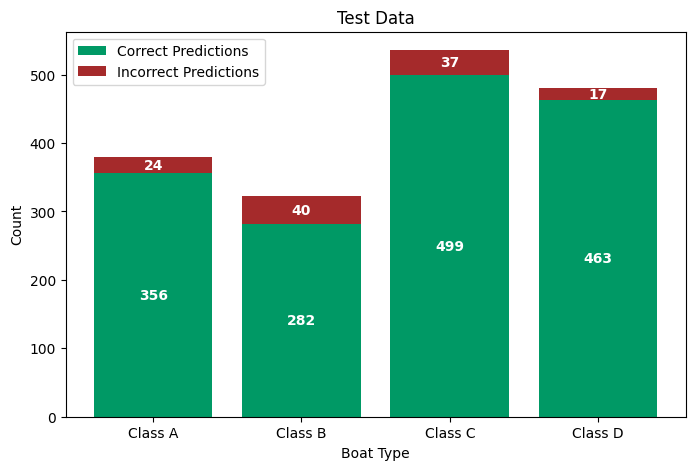

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      356        3       12        9
1       14      282       22        4
2       10       16      499       11
3        8        2        7      463

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.917526  0.936842  0.927083  0.931315
1  Class 1   0.930693  0.875776  0.902400  0.931315
2  Class 2   0.924074  0.930970  0.927509  0.931315
3  Class 3   0.950719  0.964583  0.957601  0.931315
Epoch 1/100
43/43 [==============================] - 10s 55ms/step - loss: 1.8432 - accuracy: 0.2763 - val_loss: 1.3642 - val_accuracy: 0.3367 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 1s 29ms/step - loss: 1.6285 - accuracy: 0.2933 - val_loss: 1.3468 - val_accuracy: 0.3476 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 1s 30ms/step - loss: 1.5394 - accuracy: 0.3071 - val_loss: 1.3374 - val_accuracy: 0.3782 - lr: 0.0010
Epoch 4/100
43/43 [==============================] - 1s 

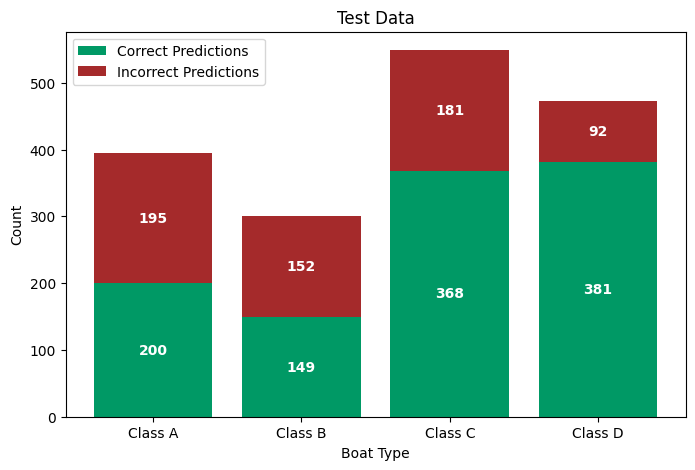

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      200       17       54      124
1       34      149       75       43
2       56       43      368       82
3       42       10       40      381

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.602410  0.506329  0.550206  0.639115
1  Class 1   0.680365  0.495017  0.573077  0.639115
2  Class 2   0.685289  0.670310  0.677716  0.639115
3  Class 3   0.604762  0.805497  0.690843  0.639115
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_42 (GRU)                (None, 6, 128)            55680     
                                                                 
 dropout_78 (Dropout)        (None, 6, 128)            0         
                                                                 
 gru_43 (GRU)                (None, 64)                37248     
                                     

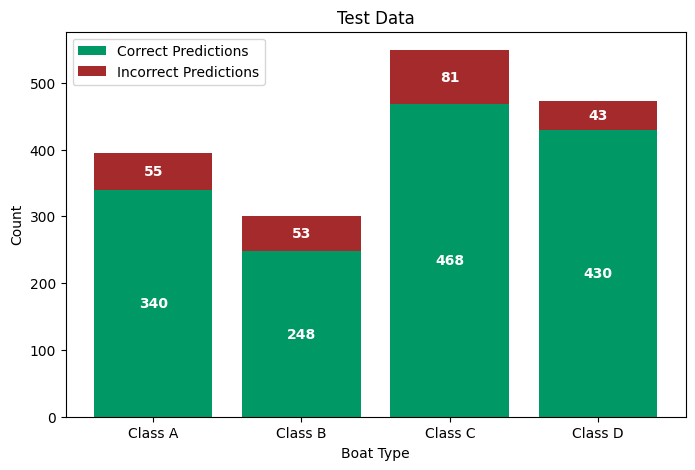

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      340        9       24       22
1       11      248       30       12
2       29       19      468       33
3       18        7       18      430

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.854271  0.860759  0.857503  0.864959
1  Class 1   0.876325  0.823920  0.849315  0.864959
2  Class 2   0.866667  0.852459  0.859504  0.864959
3  Class 3   0.865191  0.909091  0.886598  0.864959
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_44 (GRU)                (None, 1, 128)            443520    
                                                                 
 dropout_82 (Dropout)        (None, 1, 128)            0         
                                                                 
 gru_45 (GRU)                (None, 64)                37248     
                                     

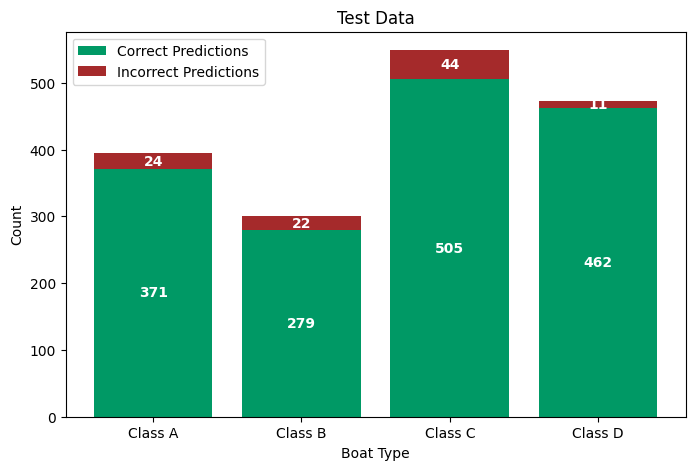

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      371        5       13        6
1        5      279       14        3
2       10       15      505       19
3        5        0        6      462

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.948849  0.939241  0.944020  0.941211
1  Class 1   0.933110  0.926910  0.930000  0.941211
2  Class 2   0.938662  0.919854  0.929163  0.941211
3  Class 3   0.942857  0.976744  0.959502  0.941211
Epoch 1/100
43/43 [==============================] - 10s 56ms/step - loss: 1.7189 - accuracy: 0.2545 - val_loss: 1.3646 - val_accuracy: 0.3164 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 1s 29ms/step - loss: 1.5480 - accuracy: 0.2896 - val_loss: 1.3499 - val_accuracy: 0.3527 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 1s 29ms/step - loss: 1.4974 - accuracy: 0.3014 - val_loss: 1.3425 - val_accuracy: 0.3622 - lr: 0.0010
Epoch 4/100
43/43 [==============================] - 1s 

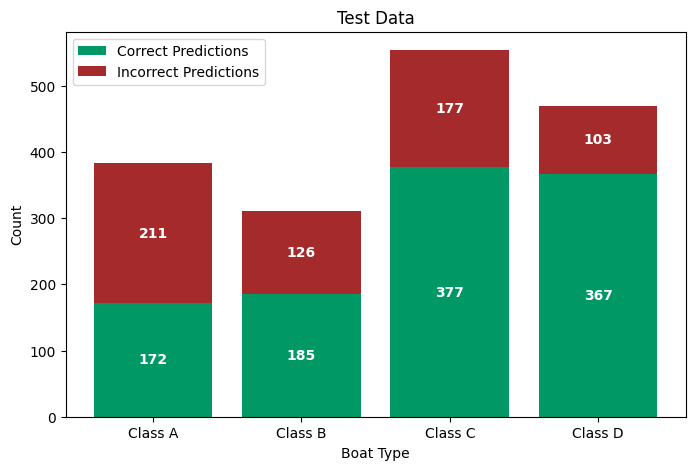

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      172       29       65      117
1       14      185       61       51
2       30       91      377       56
3       32       21       50      367

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.693548  0.449086  0.545166  0.640861
1  Class 1   0.567485  0.594855  0.580848  0.640861
2  Class 2   0.681736  0.680505  0.681120  0.640861
3  Class 3   0.620981  0.780851  0.691800  0.640861
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_49 (GRU)                (None, 6, 128)            55680     
                                                                 
 dropout_91 (Dropout)        (None, 6, 128)            0         
                                                                 
 gru_50 (GRU)                (None, 64)                37248     
                                     

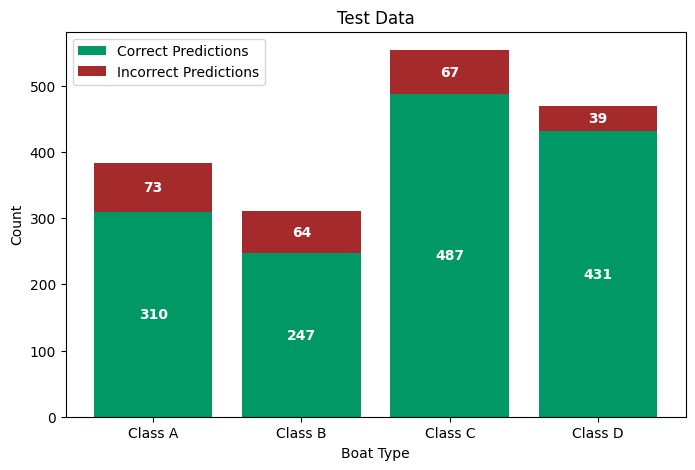

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      310       13       26       34
1       12      247       38       14
2       20       29      487       18
3       13       11       15      431

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.873239  0.809399  0.840108  0.858556
1  Class 1   0.823333  0.794212  0.808511  0.858556
2  Class 2   0.860424  0.879061  0.869643  0.858556
3  Class 3   0.867203  0.917021  0.891417  0.858556
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_51 (GRU)                (None, 1, 128)            443520    
                                                                 
 dropout_95 (Dropout)        (None, 1, 128)            0         
                                                                 
 gru_52 (GRU)                (None, 64)                37248     
                                     

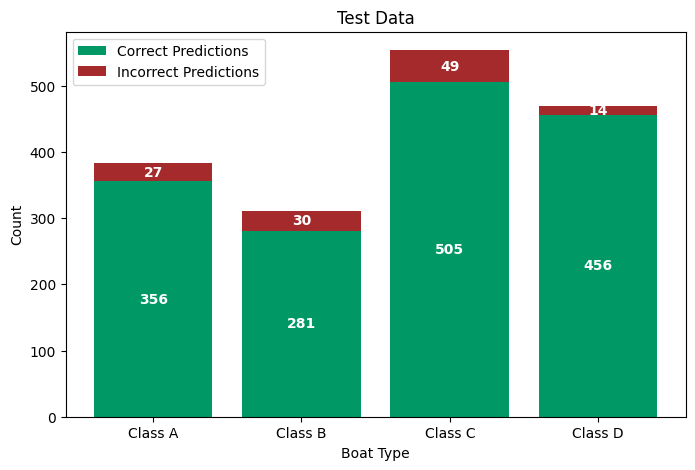

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      356        7       10       10
1        8      281       19        3
2       16       21      505       12
3        4        1        9      456

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.927083  0.929504  0.928292  0.930151
1  Class 1   0.906452  0.903537  0.904992  0.930151
2  Class 2   0.930018  0.911552  0.920693  0.930151
3  Class 3   0.948025  0.970213  0.958991  0.930151


In [ ]:
#@title 5.2 Test results extraction

# Metric activator
raw = 1
mfcc = 1
psd = 1


metrics_raw1 = []
metrics_mfcc1 = []
metrics_psd1 = []
matrix_raw = []
matrix_mfcc = []
matrix_psd = []
val = 1
data = ['data1.pkl','data2.pkl','data3.pkl','data4.pkl','data5.pkl']

for d in data:
  X_train, X_test, X_val, y_train, y_test, y_val = dataload(d)
  if raw == 1:
  # Get raw data
    X_train_r = restruct(200,25,X_train)
    X_test_r = restruct(200,25,X_test)
    X_val_r = restruct(200,25,X_val)
    metrics, matrix = get_GRU_raw(val)
    metrics_raw1.append(metrics)
    matrix_raw.append(matrix)
  if mfcc == 1:
  # Get mfcc data
    mfcc_train, mfcc_val, mfcc_test = get_mfcc()

    mfcc_train_r = restruct(6,15,mfcc_train)
    mfcc_test_r = restruct(6,15,mfcc_test)
    mfcc_val_r = restruct(6,15, mfcc_val)
    metrics1, matrix1 = get_GRU_mfcc(val)
    metrics_mfcc1.append(metrics1)
    matrix_mfcc.append(matrix1)
 # Get psd data
  if psd == 1:
    psd_train, psd_val, psd_test = get_psd()
    psd_train_r = restruct(1,1025,psd_train)
    psd_test_r = restruct(1,1025,psd_test)
    psd_val_r = restruct(1,1025, psd_val)
    metrics2, matrix2 = get_GRU_psd(val)
    metrics_psd1.append(metrics2)
    matrix_psd.append(matrix2)
  val = val + 1

pd.options.display.float_format = '{:.3f}'.format

if raw == 1:
  metrics_raw = metrics_avg_var(metrics_raw1)
if mfcc == 1:
  metrics_mfcc = metrics_avg_var(metrics_mfcc1)
if psd == 1:
  metrics_psd = metrics_avg_var(metrics_psd1)


In [ ]:
#@title Print Table

def get_number(row,col, metrics):
 cols = ['Precision','Recall','F1 Score']
 a = metrics.at[row,col]
 highest = 0
 if col in cols:
  for value in metrics[col]:
    if value > a:
      highest = 1
  if highest == 0:
    a = "\highest{" + str(a) + "}"
 return str(a)

def print_table(metrics):

#metrics table formatting


  columns_to_format = ['Precision',
                        'Recall',
                        'F1 Score',
                          'Accuracy']
  metrics[columns_to_format] = metrics[columns_to_format].round(3)
  columns_to_format = ['P_std','R_std','F1_std','Acc_std']
  metrics[columns_to_format] = metrics[columns_to_format].round(3)


  print(
  "Class A                           & " + get_number(0,'Precision',metrics) + "                               & (" + get_number(0,'P_std',metrics) + ")     & " + get_number(0,'Recall',metrics) + "                         & (" + get_number(0,'R_std',metrics) + ")         & " + get_number(0,'F1 Score',metrics) + "                  & (" + get_number(0,'F1_std',metrics) + ")                   \\\\"
  " \\rowcolor[HTML]{EFEFEF} Class B                           & " + get_number(1,'Precision',metrics) + "                               & (" + get_number(1,'P_std',metrics) + ")      & " + get_number(1,'Recall',metrics) + "                         & (" + get_number(1,'R_std',metrics) + ")         & " + get_number(1,'F1 Score',metrics) + "                  & (" + get_number(1,'F1_std',metrics) + ")                  \\\\"
  "Class C                           & " + get_number(2,'Precision',metrics) + "                               & (" + get_number(2,'P_std',metrics) + ")      & " + get_number(2,'Recall',metrics) + "                        & (" + get_number(2,'R_std',metrics) + ")         & " + get_number(2,'F1 Score',metrics) + "                  & (" + get_number(2,'F1_std',metrics) + ")                  \\\\")
  print("\\rowcolor[HTML]{EFEFEF} "
  "Class D                           & " + get_number(3,'Precision',metrics) + "                              & (" + get_number(3,'P_std',metrics) + ")      & " + get_number(3,'Recall',metrics) + "                         & (" + get_number(3,'R_std',metrics) + ")         & " + get_number(3,'F1 Score',metrics) + "                  & (" + get_number(3,'F1_std',metrics) + ")                 \\\\ \midrule"
  "\\multicolumn{1}{c}{\\textbf{Accuracy($\sigma$)}} & \multicolumn{1}{c}{\\textbf{}}       &            & \multicolumn{1}{l}{}          &               & \\textbf{" + get_number(3,'Accuracy',metrics) + "}         & \\textbf{(" + get_number(2,'Acc_std',metrics) + ")}  ")
  return


print_table(metrics_psd
            )

Class A                           & 0.924                               & (0.014)     & 0.939                         & (0.006)         & 0.931                  & (0.006)                   \\ \rowcolor[HTML]{EFEFEF} Class B                           & 0.922                               & (0.012)      & 0.89                         & (0.024)         & 0.906                  & (0.013)                  \\Class C                           & 0.93                               & (0.012)      & 0.919                        & (0.006)         & 0.924                  & (0.006)                  \\
\rowcolor[HTML]{EFEFEF} Class D                           & \highest{0.951}                              & (0.007)      & \highest{0.971}                         & (0.006)         & \highest{0.961}                  & (0.005)                 \\ \midrule\multicolumn{1}{c}{\textbf{Accuracy($\sigma$)}} & \multicolumn{1}{c}{\textbf{}}       &            & \multicolumn{1}{l}{}          &               & \te

In [ ]:
#@title Print Matrix

def get_max_matrix(matrix):
  a = 0
  pos = 5
  tp_max = 0
  for m in matrix:
    tp = sum(np.diagonal(m))
    if tp_max < tp:
      tp_max = tp
      pos = a
    a = a+1
  return pos

def get_matrix(matrix):
  matrix = matrix[get_max_matrix(matrix)]
  col = ['Class A','Class B','Class C','Class D']
  for i in list(range(4)):
    for j in list(range(4)):
      print(j,i,matrix.at[i,col[j]])

print("x y C")
get_matrix(matrix_psd
           )


x y C
0 0 371
1 0 5
2 0 13
3 0 6
0 1 5
1 1 279
2 1 14
3 1 3
0 2 10
1 2 15
2 2 505
3 2 19
0 3 5
1 3 0
2 3 6
3 3 462
